# TPC-C Multi-Tenant in PostgreSQL with Preloaded Distributed PVC

* data has been loaded into databases in a distributed filesystem
* experiments use this preloaded data

In [1]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
#import os
#import re
import matplotlib.pyplot as plt
#import pickle
from IPython.display import display, Markdown
import seaborn as sns
from math import floor
import ast
import json
import re
import numpy as np

#import dbmsbenchmarker
#import bexhoma
from bexhoma import evaluators

%matplotlib inline

In [2]:
#path = r"C:\data\benchmarks"
path = r"/home/perdelt/benchmarks"
filename_prefix = "pvc_load_"

In [3]:
def get_workload(code):
    with open(path+"/"+code+"/queries.config",'r') as inp:
        workload_properties = ast.literal_eval(inp.read())
        return workload_properties


def get_performance_single(evaluation):
    df = evaluation.get_df_benchmarking()
    df = df.sort_values(['experiment_run', 'client'])
    return df

def get_performance(evaluation):
    df = evaluation.get_df_benchmarking()
    df = df.sort_values(['experiment_run', 'client'])
    result = df.groupby('client').agg({
        'Goodput (requests/second)': 'sum',
        'num_errors': 'sum',
        'Latency Distribution.Average Latency (microseconds)': 'mean',
        'Latency Distribution.99th Percentile Latency (microseconds)': 'max',
    }).reset_index()
    return result

def get_performance_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_performance_all_single(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance_single(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_loading_time_max(evaluation):
    with open(path+"/"+evaluation.code+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
        pretty_connections = json.dumps(connections, indent=2)
        #print(pretty_connections)
        connections_sorted = sorted(connections, key=lambda c: c['name'])
        result = dict()
        for c in connections_sorted:
            result[c['name']] = {
                'time_load': c['timeLoad'],
                'time_ingest': c['timeIngesting'],
                'time_check': c['timeIndex'],
                'terminals': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS'],
                #'target': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TARGET'],
                'pods': c['parameter']['parallelism'],
                'tenant': c['parameter']['TENANT'] if 'TENANT' in c['parameter'] else '',
                'client': c['parameter']['client'],
                'datadisk': c['hostsystem']['datadisk'],
            }
            #result[c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS']] = c['timeIngesting']
        df = pd.DataFrame(result).T
        return df#df['time_load'].max()

def get_loading_time_max_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_loading_time_max(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def show_summary_monitoring_table(evaluate, component):
    df_monitoring = list()
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util_s', component=component)
    df = df.max().sort_index() - df.min().sort_index() # compute difference of counter
    #df = df.T.max().sort_index() - df.T.min().sort_index() # compute difference of counter
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["CPU [CPUs]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util', component=component)
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max CPU"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df).round(2)
    df_cleaned.columns = ["Max RAM [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory_cached', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory_cached')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max RAM Cached [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    return df_monitoring

def get_monitoring_stream_single(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        return df

def get_monitoring(evaluation, type="stream"):
    df_monitoring = show_summary_monitoring_table(evaluation, type)
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        result = df.groupby('client').agg({
            'CPU [CPUs]': 'sum',
            'Max RAM [Gb]': 'sum',
            'Max RAM Cached [Gb]': 'sum',
            'Max CPU': 'sum',
        }).reset_index()
        return result

def get_monitoring_stream(evaluation):
    return get_monitoring(evaluation, type="stream")

def get_monitoring_all(codes, type="stream"):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_monitoring(evaluation, type)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_monitoring_stream_all(codes):
    return get_monitoring_all(codes, type="stream")


In [4]:
def sanitize_filename(title, max_length=100):
    # Replace non-alphanumeric characters with underscores
    safe = re.sub(r'[^a-zA-Z0-9-_]+', '_', title.strip())
    # Truncate to a safe length
    return safe[:max_length].rstrip('_')
    
def plot_bars(df, y, title, estimator):
    df_plot = df.copy()
    #df_plot = df_plot[df_plot['client']=='1']
    df_plot = df_plot.sort_values(['num_tenants','type'])
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_plot,
        x='num_tenants',
        y=y,
        hue='type',
        estimator=estimator,
        palette='Set2',
        hue_order=hue_order
    )
    show_height = False
    if show_height:
        for bar in ax.patches:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,  # X: center of bar
                    height,                             # Y: top of bar
                    f'{height:.1f}',                    # Text (1 decimal place)
                    ha='center', va='bottom', fontsize=8
                )
    # Get tick positions (i.e., the x-axis categories)
    xticks = ax.get_xticks()
    bar_width = ax.patches[0].get_width()
    # Create a mapping from (num_tenants, type) to hatch
    grouped = df_plot.groupby(['num_tenants', 'type']).agg({y: estimator}).reset_index()
    #print(grouped)
    grouped_dict = {(row['num_tenants'], row['type']): hatch_map[row['type']] for _, row in grouped.iterrows()}
    bars = sorted(ax.patches, key=lambda bar: bar.get_x() if bar.get_height() > 0 else 10000)
    for bar, (_, row) in zip(bars, grouped.iterrows()):
        bar.my_id = (row['num_tenants'], row['type'])  # or anything else like an index or uuid
        bar.set_hatch(hatch_map[row['type']]) #grouped_dict[(bar.my_id)])
        bar.set_edgecolor('black')
        bar.set_linewidth(1)
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
    # Final touches
    plt.legend(title='Type')
    ax.legend(fontsize=18)
    #ax.legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))  # move outside
    plt.title(f"{title}", fontsize=24)
    #plt.title(f"{title} by Number of Tenants and Type", fontsize=24)
    plt.xlabel("Number of Tenants", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    # Remove y-axis label
    ax.set_ylabel('')  # or ax.set(ylabel='')
    plt.tight_layout()
    filename = "tpcc_" + filename_prefix + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()



In [5]:
def plot_boxplots(df, y, title):
    plt.figure(figsize=(10, 6))
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    
    # Plot boxplots grouped by num_tenants and colored by type
    ax = sns.boxplot(
        data=df,
        x='num_tenants',
        y=y,#'Goodput (requests/second)',
        hue='type',
        palette='Set2'  # consistent colors per type
    )
    # Add vertical separator lines between groups
    # Get the number of unique num_tenants and type
    num_groups = df['num_tenants'].nunique()
    num_types = df['type'].nunique()
    
    # Extract hue order
    hue_order = ax.get_legend_handles_labels()[1]
    num_hue = len(hue_order)
    
    # Get hue order from seaborn (types)
    _, type_order = ax.get_legend_handles_labels()
    num_types = len(type_order)
    
    #print(len(ax.patches))
    # Set hatches correctly: patches are grouped by x then by hue
    for i, patch in enumerate(ax.patches):
        #print(i)
        type_index = i // (num_groups)
        if type_index >= num_types:
            break
        type_name = type_order[type_index]
        patch.set_hatch(hatch_map.get(type_name, ''))
        #print(hatch_map.get(type_name, ''))
        patch.set_edgecolor('black')
        patch.set_linewidth(1)
    
    # Each num_tenants group has num_types boxes
    for i in range(1, num_groups):
        xpos = i - 0.5 #0.5
        ax.axvline(x=xpos, color='gray', linestyle='--', alpha=0.5)
    
    
    # Update legend with matching hatches
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
        handle.set_edgecolor('black')
        handle.set_linewidth(1)
    
    #title = "Goodput [req/s] Distribution per Tenant"
    plt.title(title, fontsize=24)
    plt.xlabel("Number of Tenants")
    plt.ylabel("")#"Goodput (requests/second)")
    plt.xlabel("Number of Tenants", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    plt.legend(title="Type")
    ax.legend(fontsize=18)
    plt.tight_layout()
    filename = "tpcc_" + filename_prefix + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

# Container

In [6]:
codes = [
    # container
    '1751877039', #tenants=1
    #'1751970668', #tenants=1 new args
    '1751881521', #tenants=2
    '1751886078', #tenants=3
    '1751890787', #tenants=4
    '1751895599', #tenants=5
    '1751900409', #tenants=6
    '1751905370', #tenants=7
    '1751910445', #tenants=8
    '1751915542', #tenants=9
    '1751920724', #tenants=10
    #'1751962416', #tnenats=10 new args
    
    # database
    '1751875517', #tenants=1
    #'', #tenants=1 new args
    '1751880029', #tenants=2
    '1751884579', #tenants=3
    '1751889257', #tenants=4
    '1751894056', #tenants=5
    '1751898888', #tenants=6
    '1751903820', #tenants=7
    '1751908830', #tenants=8
    '1751913956', #tenants=9
    '1751919169', #tenants=10
    #'1751960852', #tnenats=10 new args
    
    #schema
    '1751873991', #tenants=1
    #'1751967562', #tenants=1 new args
    '1751878536', #tenants=2
    #'1751972199', #tenants=2 new args
    '1751883081', #tenants=3
    '1751887694', #tenants=4
    '1751892497', #tenants=5
    '1751897336', #tenants=6   
    '1751902260', #tenants=7
    '1751907276', #tenants=8
    '1751912346', #tenants=9
    '1751917587', #tenants=10
    #'1751959280', #tnenats=10 new args
]

codes

['1751877039',
 '1751881521',
 '1751886078',
 '1751890787',
 '1751895599',
 '1751900409',
 '1751905370',
 '1751910445',
 '1751915542',
 '1751920724',
 '1751875517',
 '1751880029',
 '1751884579',
 '1751889257',
 '1751894056',
 '1751898888',
 '1751903820',
 '1751908830',
 '1751913956',
 '1751919169',
 '1751873991',
 '1751878536',
 '1751883081',
 '1751887694',
 '1751892497',
 '1751897336',
 '1751902260',
 '1751907276',
 '1751912346',
 '1751917587']

In [7]:
df_performance = get_performance_all_single(codes)
df_performance

,connection,configuration,experiment_run,client,pod,pod_count,bench,profile,target,time,...,Latency Distribution.Maximum Latency (microseconds),Latency Distribution.Median Latency (microseconds),Latency Distribution.Minimum Latency (microseconds),Latency Distribution.25th Percentile Latency (microseconds),Latency Distribution.90th Percentile Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),Latency Distribution.75th Percentile Latency (microseconds),Latency Distribution.Average Latency (microseconds),type,num_tenants
connection_pod,,,,,,,,,,,,,,,,,,,,,
PostgreSQL-1-1-65536-0-1-1,PostgreSQL-1-1-65536-0-1,PostgreSQL-1-1-65536-0,1,1,6xkg8.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,8777188,52195,716,19723,124654,310677,95037,65806,container,1
PostgreSQL-1-1-65536-0-2-1,PostgreSQL-1-1-65536-0-2,PostgreSQL-1-1-65536-0,1,2,hxgm8.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,1063258,19437,789,13585,49545,106697,31021,25633,container,1
PostgreSQL-1-1-65536-0-1-1,PostgreSQL-1-1-65536-0-1,PostgreSQL-1-1-65536-0,1,1,mw9z7.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,5913230,38810,668,19613,113538,460880,70933,61549,container,2
PostgreSQL-1-1-65536-1-1-1,PostgreSQL-1-1-65536-1-1,PostgreSQL-1-1-65536-1,1,1,pxw47.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,7572457,47016,683,20773,114852,311570,83793,61352,container,2
PostgreSQL-1-1-65536-1-2-1,PostgreSQL-1-1-65536-1-2,PostgreSQL-1-1-65536-1,1,2,58kcb.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,1884769,21561,730,13257,64436,137264,38882,30667,container,2
PostgreSQL-1-1-65536-0-2-1,PostgreSQL-1-1-65536-0-2,PostgreSQL-1-1-65536-0,1,2,r2t74.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,1590055,20738,754,12993,57695,117414,35970,28208,container,2
PostgreSQL-1-1-65536-1-1-1,PostgreSQL-1-1-65536-1-1,PostgreSQL-1-1-65536-1,1,1,hhf7v.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,9370629,41680,733,24134,106531,235616,69509,54784,container,3
PostgreSQL-1-1-65536-0-1-1,PostgreSQL-1-1-65536-0-1,PostgreSQL-1-1-65536-0,1,1,vnmrv.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,11003873,43317,692,24099,108048,225505,73788,55969,container,3
PostgreSQL-1-1-65536-2-1-1,PostgreSQL-1-1-65536-2-1,PostgreSQL-1-1-65536-2,1,1,8fb4t.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,7246445,44668,693,24818,109633,235343,75217,57124,container,3


## Per Tenant

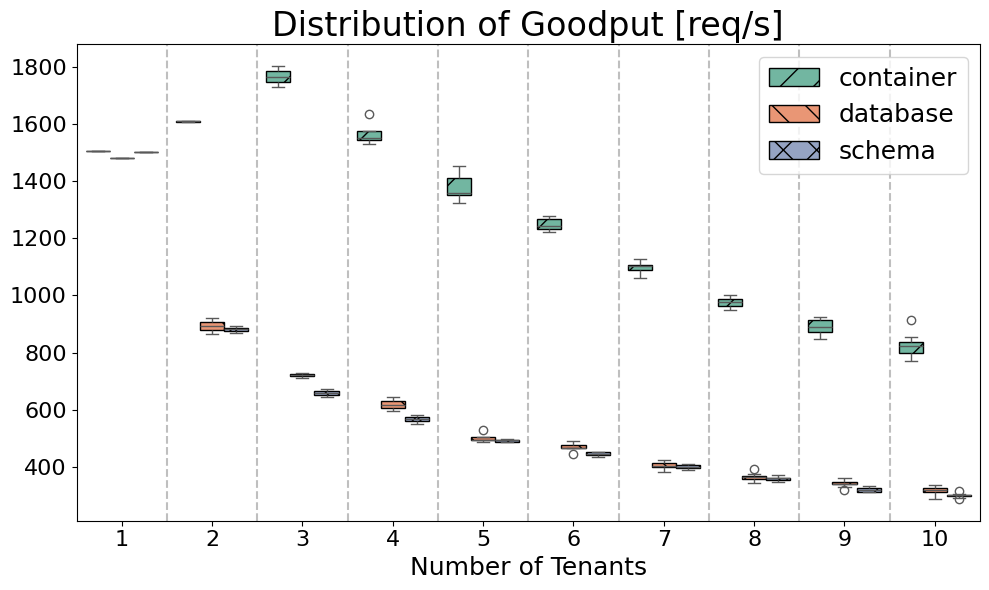

In [8]:
df = df_performance[df_performance['client']=='1']
#df = df_performance.copy()
plot_boxplots(df, y='Goodput (requests/second)', title='Distribution of Goodput [req/s]')

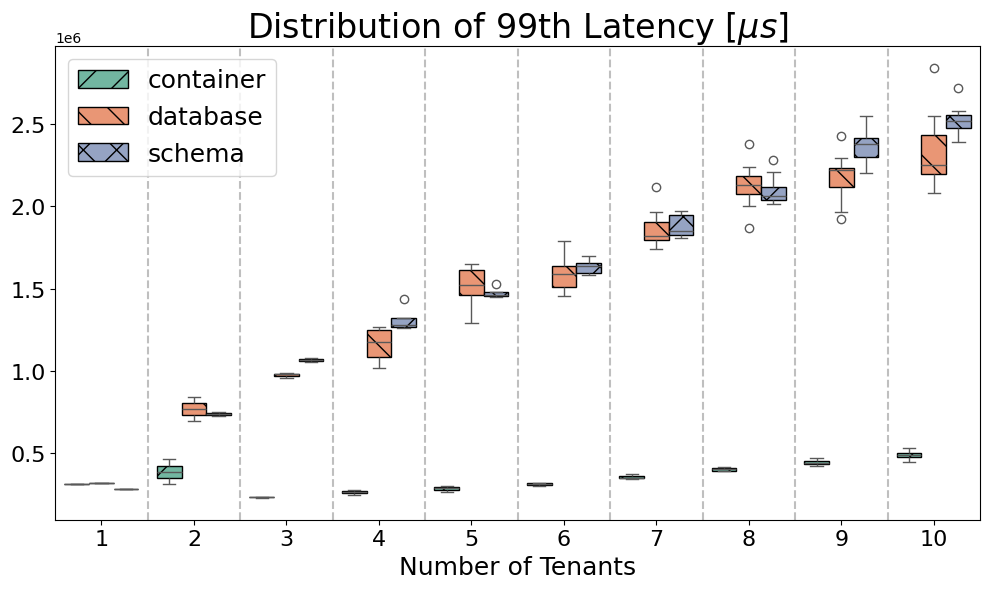

In [9]:
df = df_performance[df_performance['client']=='1']
#df = df_performance.copy()
plot_boxplots(df, y='Latency Distribution.99th Percentile Latency (microseconds)', title='Distribution of 99th Latency [$\mu s$]')


In [10]:
df_performance = get_performance_all(codes)
df_performance

,client,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),type,num_tenants
0,1,1504.911644,12,65806.000000,310677,container,1
1,2,3844.757924,45,25633.000000,106697,container,1
0,1,3218.273094,26,61450.500000,460880,container,2
1,2,6709.424544,104,29437.500000,137264,container,2
0,1,5298.052954,54,55959.000000,235616,container,3
1,2,8393.182962,134,35243.333333,151380,container,3
0,1,6268.994694,81,63032.750000,276741,container,4
1,2,9253.589020,151,42654.000000,201611,container,4
0,1,6899.754656,80,71589.800000,297600,container,5
1,2,9712.786123,191,50689.600000,221212,container,5


## Per Total

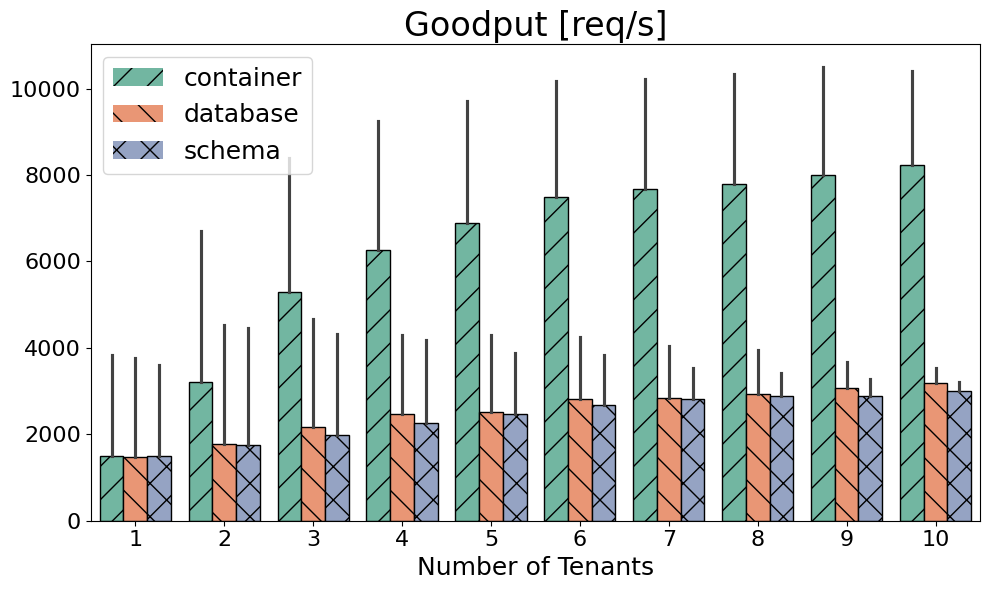

In [11]:
plot_bars(df_performance, y='Goodput (requests/second)', title='Goodput [req/s]', estimator='min')

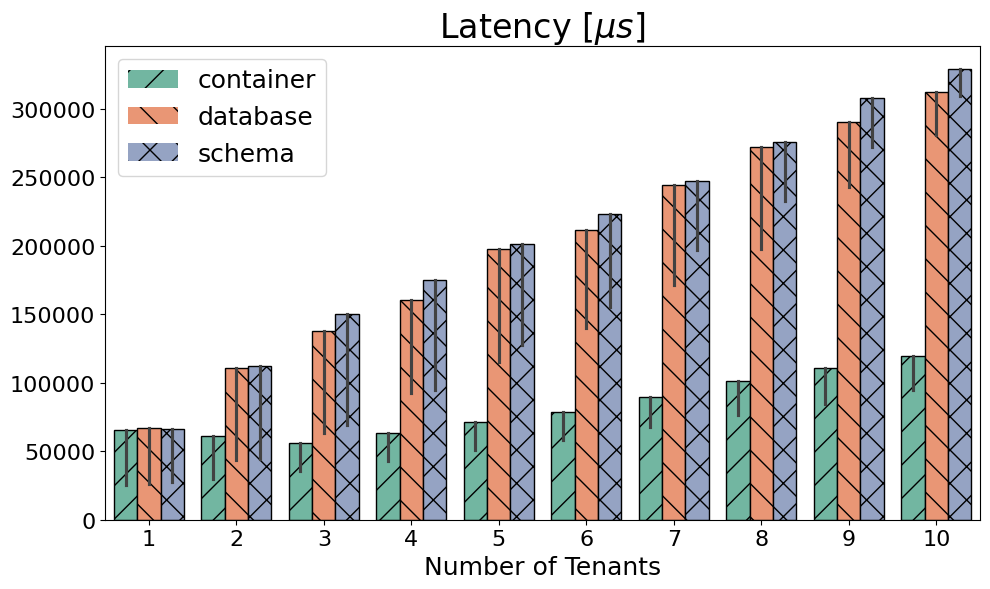

In [12]:
plot_bars(df_performance, y='Latency Distribution.Average Latency (microseconds)', title='Latency [$\mu s$]', estimator='max')

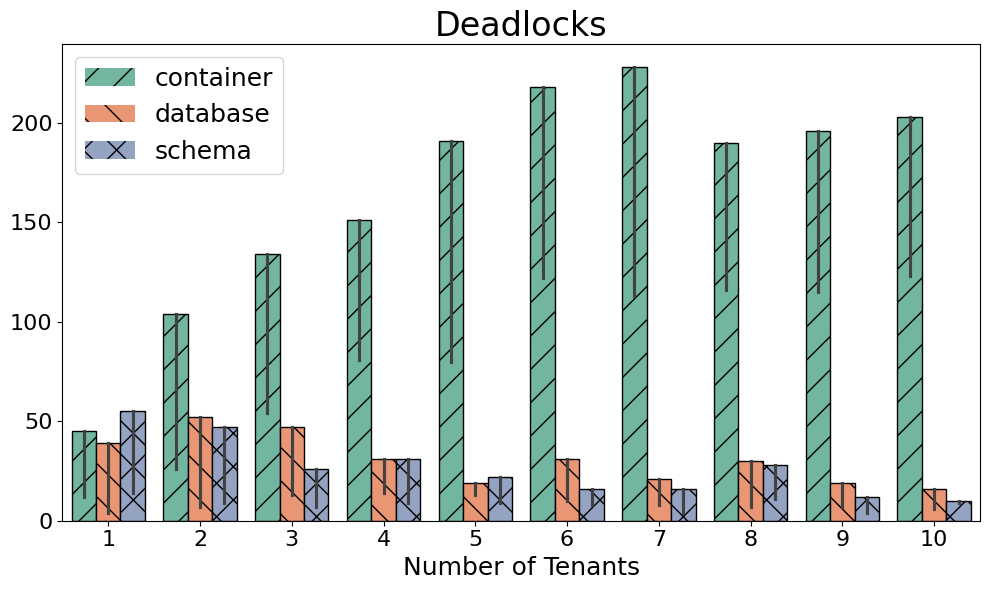

In [13]:
plot_bars(df_performance, y='num_errors', title='Deadlocks', estimator='max')

In [14]:
df_performance = get_loading_time_max_all(codes)
df_performance

,time_load,time_ingest,time_check,terminals,pods,tenant,client,datadisk,type,num_tenants
PostgreSQL-1-1-65536-0-1,280.0,108.0,169.0,1,1,0,1,2720,container,1
PostgreSQL-1-1-65536-0-2,280.0,108.0,169.0,1,1,0,2,5171,container,1
PostgreSQL-1-1-65536-0-1,387.0,136.0,248.0,1,1,0,1,2720,container,2
PostgreSQL-1-1-65536-0-2,387.0,136.0,248.0,1,1,0,2,5405,container,2
PostgreSQL-1-1-65536-1-1,364.0,121.0,240.0,1,1,1,1,2720,container,2
PostgreSQL-1-1-65536-1-2,364.0,121.0,240.0,1,1,1,2,5408,container,2
PostgreSQL-1-1-65536-0-1,360.0,108.0,249.0,1,1,0,1,2720,container,3
PostgreSQL-1-1-65536-0-2,360.0,108.0,249.0,1,1,0,2,5658,container,3
PostgreSQL-1-1-65536-1-1,348.0,104.0,241.0,1,1,1,1,2720,container,3
PostgreSQL-1-1-65536-1-2,348.0,104.0,241.0,1,1,1,2,5746,container,3


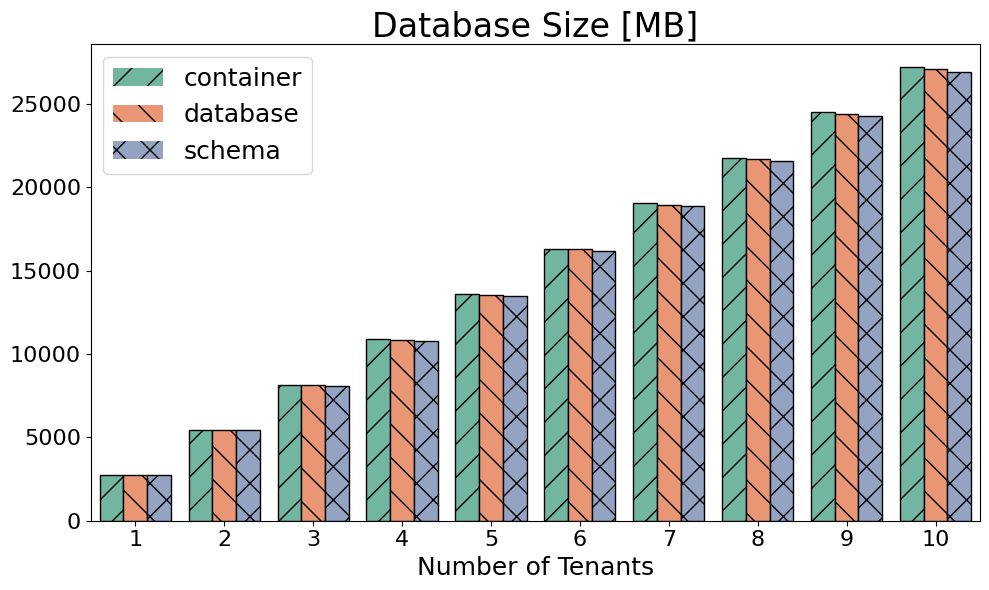

In [15]:
df_performance_first = df_performance[df_performance['client'] == '1']
plot_bars(df_performance_first, y='datadisk', title='Database Size [MB]', estimator='sum')

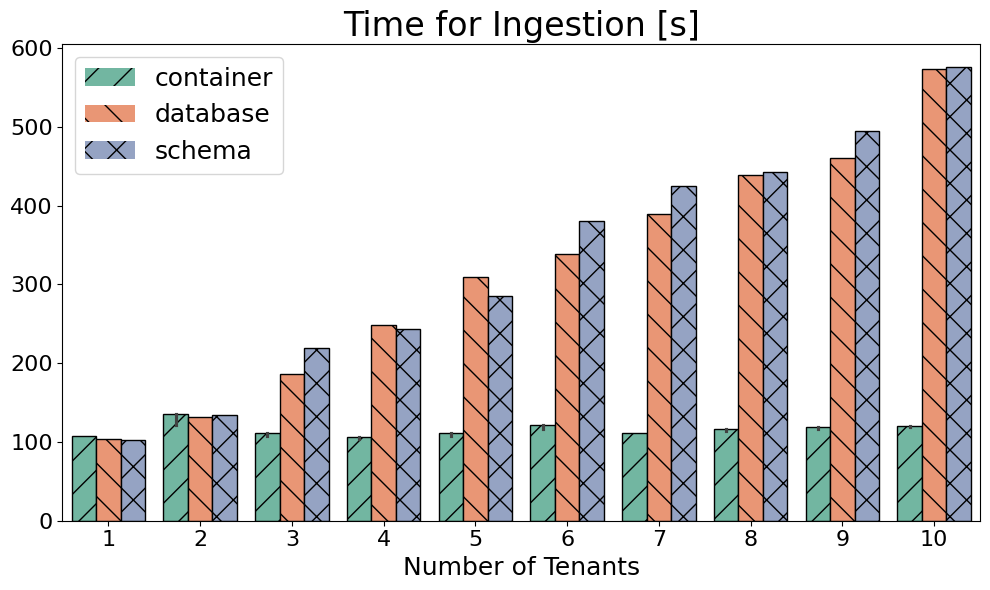

In [16]:
plot_bars(df_performance, y='time_ingest', title='Time for Ingestion [s]', estimator='max')

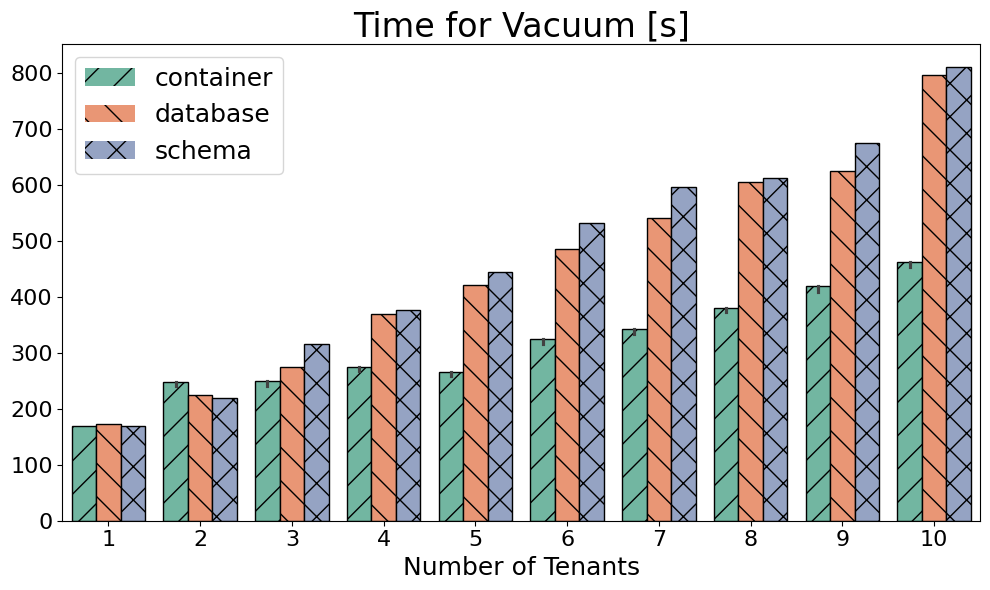

In [17]:
plot_bars(df_performance, y='time_check', title='Time for Vacuum [s]', estimator='max')

## Hardware Benchmarking

In [18]:
df_performance = get_monitoring_stream_all(codes)
df_performance = df_performance[df_performance['client'] == '1']
df_performance

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,type,num_tenants
0,1,7749.14,5.01,7.30,15.12,container,1
0,1,18031.47,10.07,14.67,40.03,container,2
0,1,27271.83,15.38,22.51,49.51,container,3
0,1,31182.81,19.85,28.87,55.26,container,4
0,1,32777.03,24.16,34.93,57.37,container,5
0,1,33859.68,28.50,41.04,58.36,container,6
0,1,34214.29,32.54,46.65,59.10,container,7
0,1,34808.15,36.39,51.95,59.79,container,8
0,1,35408.16,40.55,57.76,60.81,container,9
0,1,35417.20,44.51,63.26,60.72,container,10


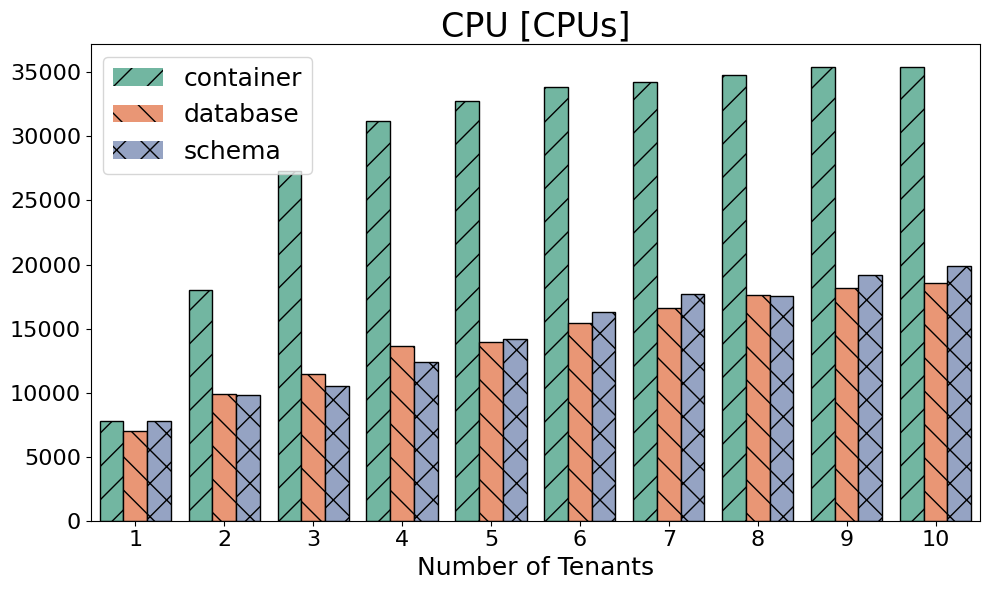

In [19]:
plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

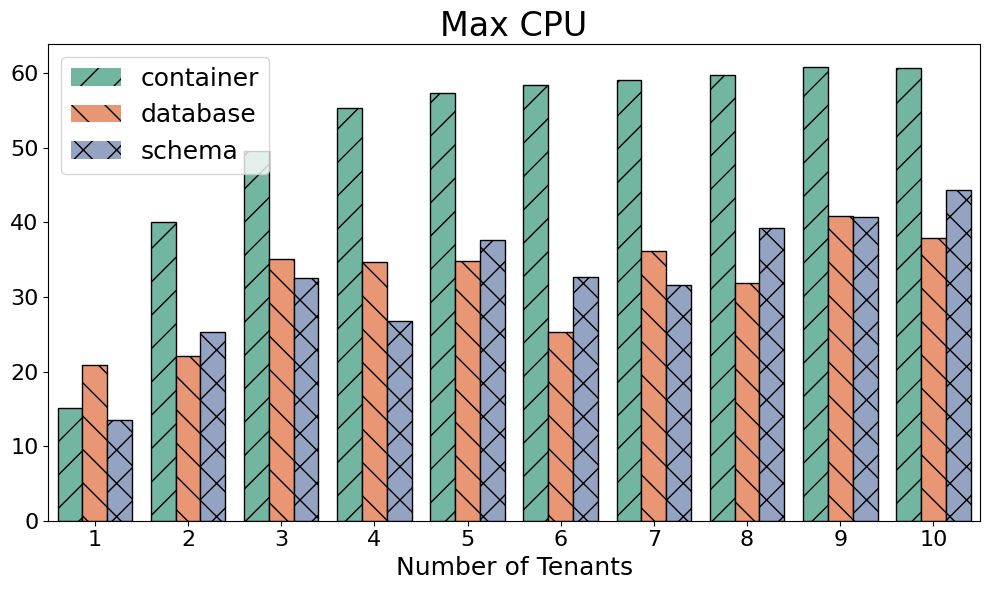

In [20]:
plot_bars(df_performance, y='Max CPU', title='Max CPU', estimator='sum')

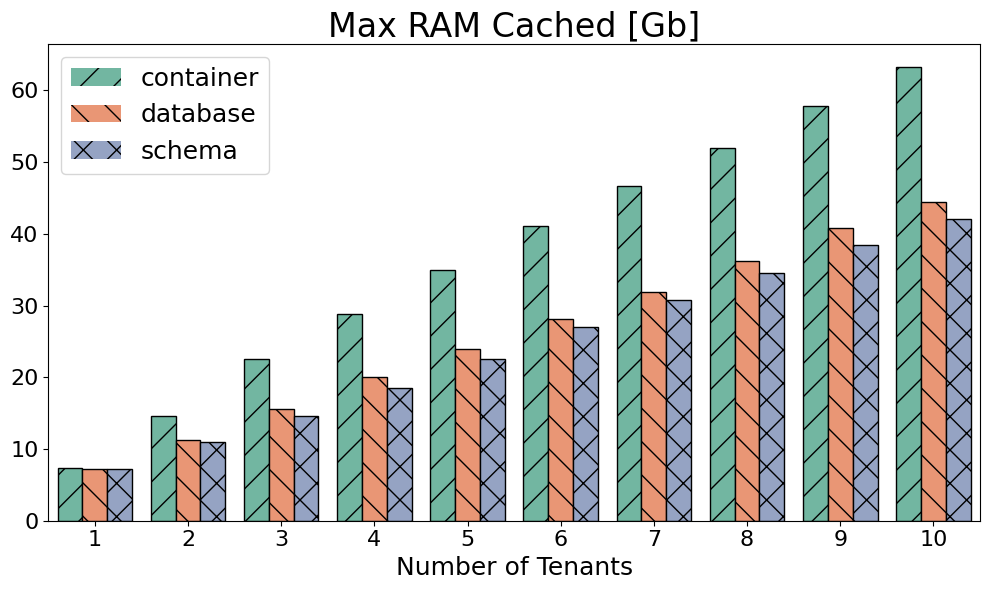

In [21]:
plot_bars(df_performance, y='Max RAM Cached [Gb]', title='Max RAM Cached [Gb]', estimator='sum')

## Hardware Loading

In [22]:
#df_performance = get_monitoring_all(codes, "loading")
#df_performance = df_performance[df_performance['client'] == '1']
#df_performance

In [23]:
#plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

In [24]:
#plot_bars(df_performance, y='Max CPU', title='Max CPU', estimator='sum')

In [25]:
#plot_bars(df_performance, y='Max RAM Cached [Gb]', title='Max RAM Cached [Gb]', estimator='sum')

# Efficiency

In [26]:
client = '1'

df_performance_monitoring = get_monitoring_stream_all(codes)
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = get_performance_all(codes)
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants'], how='inner')
#merged_df['CPUs/Request'] = merged_df['CPU [CPUs]'] / merged_df['Goodput (requests/second)'] / 600.
merged_df['E_Tpx'] = merged_df['Goodput (requests/second)'] / merged_df['CPU [CPUs]'] * 600.
merged_df['E_Lat'] = 1./np.sqrt(merged_df['Latency Distribution.Average Latency (microseconds)']*merged_df['CPU [CPUs]']/1E6)
merged_df['I_Lat'] = 1./merged_df['E_Lat']
#merged_df['E_Lat'] = 1./(merged_df['Latency Distribution.Average Latency (microseconds)']*merged_df['CPU [CPUs]']/1E6)
merged_df['E_RAM'] = (merged_df['Goodput (requests/second)']) / merged_df['Max RAM [Gb]']
merged_df

,client_x,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),type,num_tenants,client_y,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,E_Tpx,E_Lat,I_Lat,E_RAM
0,1,1504.911644,12,65806.000000,310677,container,1,1,7749.14,5.01,7.30,15.12,116.522219,0.044283,22.581849,300.381566
1,1,3218.273094,26,61450.500000,460880,container,2,1,18031.47,10.07,14.67,40.03,107.088543,0.030042,33.287278,319.590178
2,1,5298.052954,54,55959.000000,235616,container,3,1,27271.83,15.38,22.51,49.51,116.561000,0.025598,39.065385,344.476785
3,1,6268.994694,81,63032.750000,276741,container,4,1,31182.81,19.85,28.87,55.26,120.624049,0.022556,44.334391,315.818373
4,1,6899.754656,80,71589.800000,297600,container,5,1,32777.03,24.16,34.93,57.37,126.303475,0.020644,48.440696,285.585872
5,1,7492.823904,122,78975.666667,320155,container,6,1,33859.68,28.50,41.04,58.36,132.774271,0.019338,51.711612,262.906102
6,1,7686.283040,113,89812.285714,374634,container,7,1,34214.29,32.54,46.65,59.10,134.790750,0.018040,55.433416,236.210296
7,1,7804.127787,116,101068.875000,415911,container,8,1,34808.15,36.39,51.95,59.79,134.522423,0.016860,59.312904,214.458032
8,1,7999.849546,115,110965.444444,470459,container,9,1,35408.16,40.55,57.76,60.81,135.559423,0.015953,62.682392,197.283589
9,1,8234.971304,123,119933.200000,531879,container,10,1,35417.20,44.51,63.26,60.72,139.508001,0.015343,65.174367,185.013959


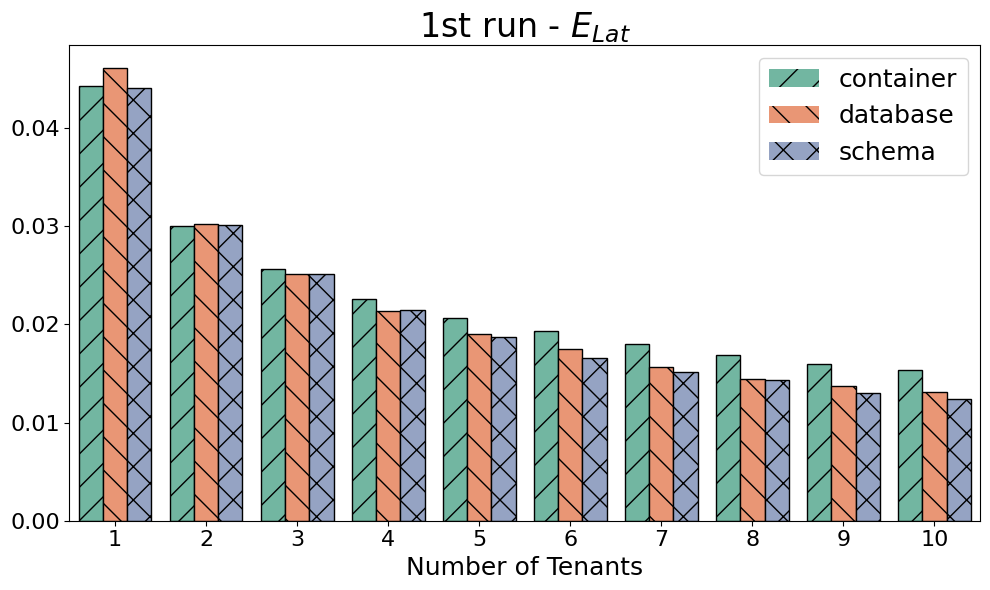

In [27]:
plot_bars(merged_df, y='E_Lat', title='1st run - $E_{Lat}$', estimator='max')

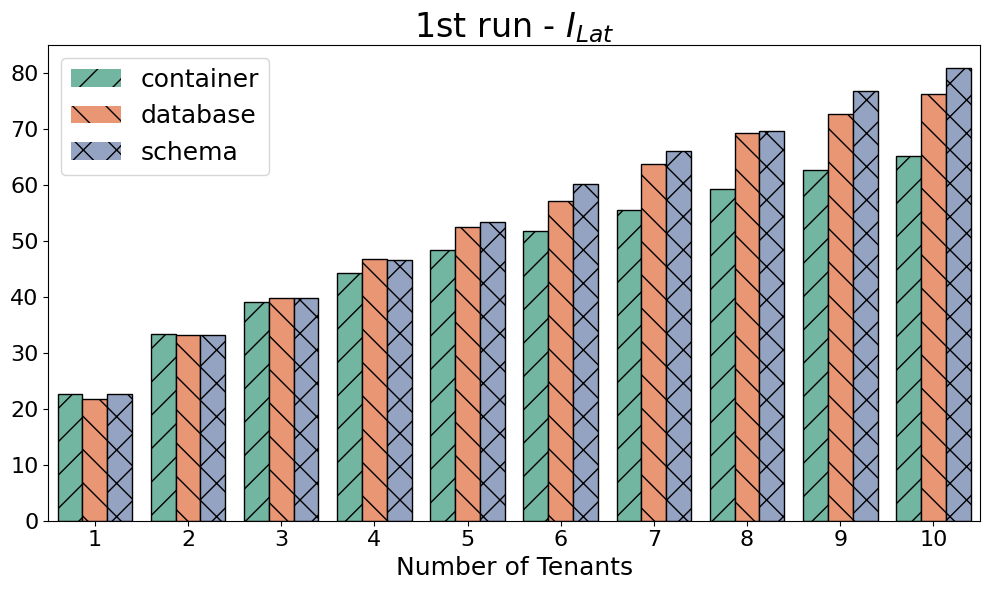

In [28]:
plot_bars(merged_df, y='I_Lat', title='1st run - $I_{Lat}$', estimator='max')

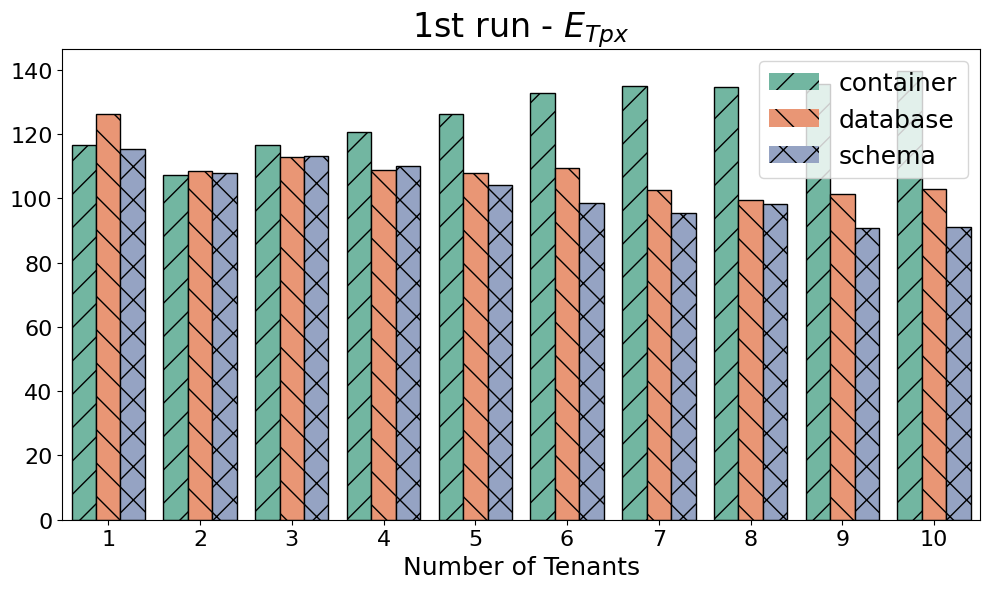

In [29]:
plot_bars(merged_df, y='E_Tpx', title='1st run - $E_{Tpx}$', estimator='max')

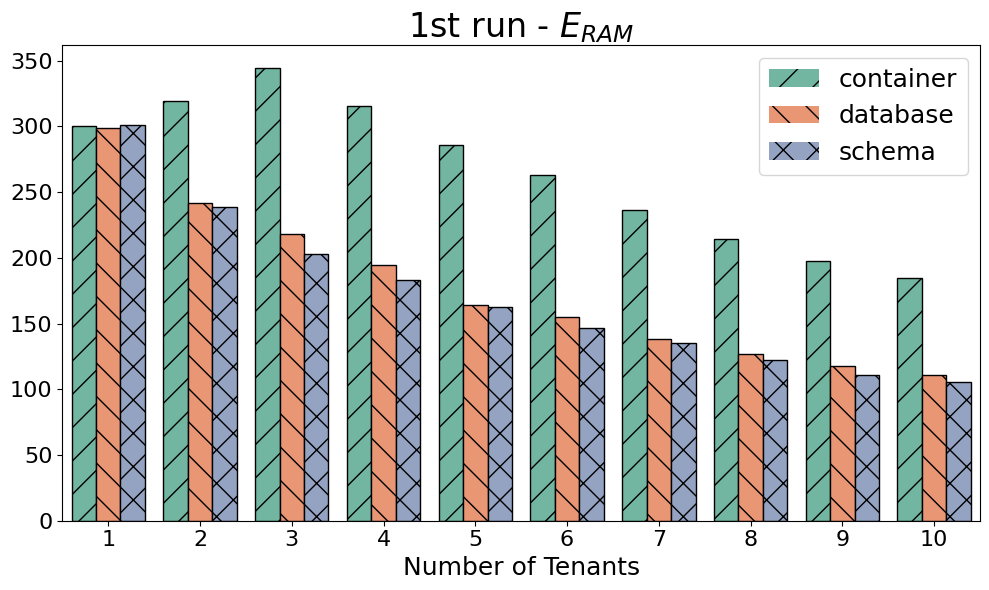

In [30]:
plot_bars(merged_df, y='E_RAM', title='1st run - $E_{RAM}$', estimator='min')

In [31]:
client = '2'

df_performance_monitoring = get_monitoring_stream_all(codes)
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = get_performance_all(codes)
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants'], how='inner')
#merged_df['CPUs/Request'] = merged_df['CPU [CPUs]'] / merged_df['Goodput (requests/second)'] / 600.
merged_df['E_Tpx'] = merged_df['Goodput (requests/second)'] / merged_df['CPU [CPUs]'] * 600.
merged_df['E_Lat'] = 1./np.sqrt(merged_df['Latency Distribution.Average Latency (microseconds)']*merged_df['CPU [CPUs]']/1E6)
merged_df['E_RAM'] = (merged_df['Goodput (requests/second)']) / merged_df['Max RAM [Gb]']

merged_df

,client_x,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),type,num_tenants,client_y,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,E_Tpx,E_Lat,E_RAM
0,2,3844.757924,45,25633.000000,106697,container,1,2,12994.08,7.37,11.58,22.87,177.531211,0.054793,521.676787
1,2,6709.424544,104,29437.500000,137264,container,2,2,23537.03,14.08,21.96,42.04,171.034949,0.037990,476.521630
2,2,8393.182962,134,35243.333333,151380,container,3,2,26685.39,20.44,31.70,46.86,188.714116,0.032608,410.625390
3,2,9253.589020,151,42654.000000,201611,container,4,2,30786.23,25.28,38.71,52.30,180.345350,0.027596,366.043869
4,2,9712.786123,191,50689.600000,221212,container,5,2,31163.15,30.19,45.77,53.05,187.005218,0.025161,321.721965
5,2,10173.464343,218,58039.166667,280599,container,6,2,33557.99,34.84,52.47,56.56,181.896431,0.022659,292.005291
6,2,10215.227859,228,67431.285714,313133,container,7,2,33710.06,38.81,57.86,56.68,181.819217,0.020974,263.211231
7,2,10327.516122,190,76412.375000,409787,container,8,2,34871.20,43.06,63.83,59.20,177.697059,0.019372,239.840133
8,2,10499.919400,196,84548.333333,438938,container,9,2,35309.74,47.10,69.37,59.14,178.419655,0.018302,222.928225
9,2,10415.455213,203,94533.400000,515682,container,10,2,35102.98,51.21,75.03,59.23,178.026855,0.017359,203.387136


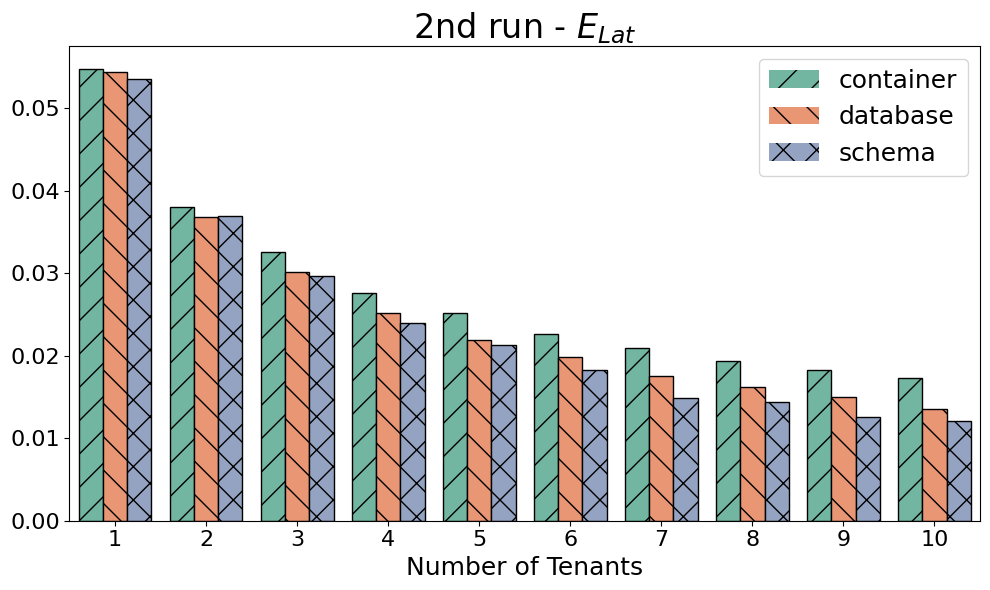

In [32]:
plot_bars(merged_df, y='E_Lat', title='2nd run - $E_{Lat}$', estimator='max')

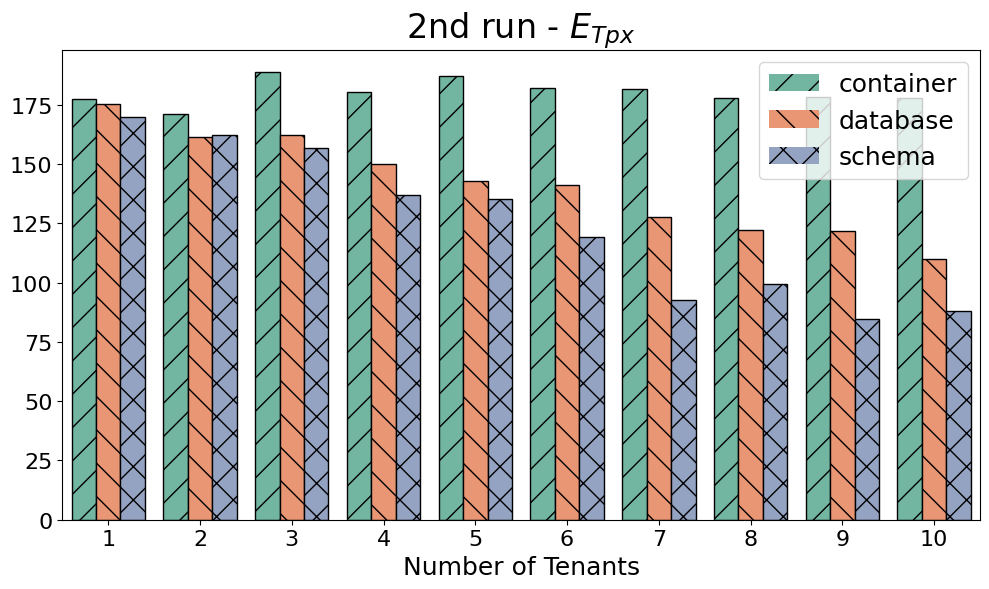

In [33]:
plot_bars(merged_df, y='E_Tpx', title='2nd run - $E_{Tpx}$', estimator='max')

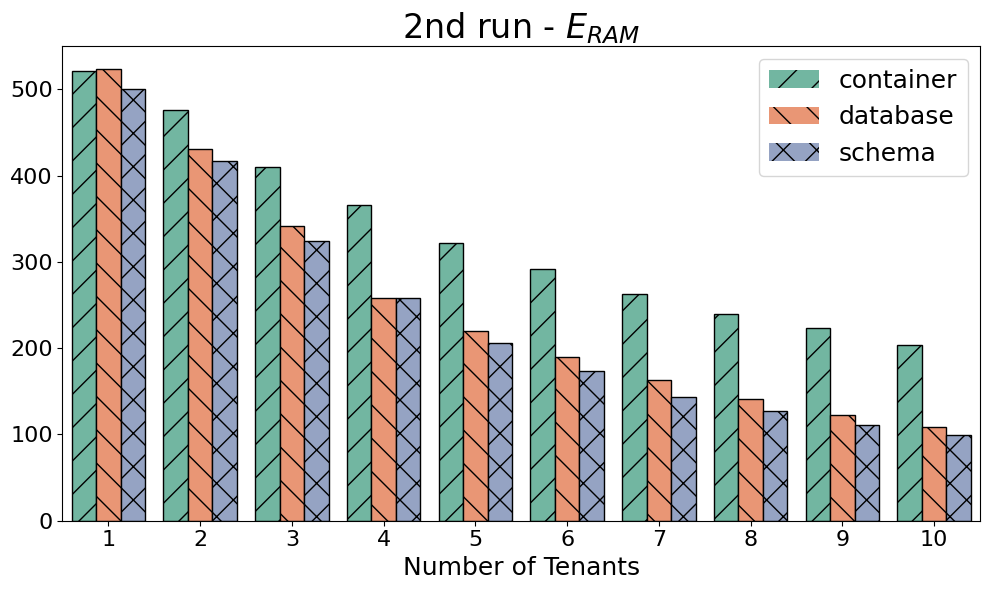

In [34]:
plot_bars(merged_df, y='E_RAM', title='2nd run - $E_{RAM}$', estimator='max')

In [35]:
import os
import zipfile

def zip_all_results():
    # Set the base directory containing the folders
    base_dir = path # "/path/to/your/folders"  # CHANGE THIS to your actual directory
    # List all folder names in the directory
    folder_names = codes
    # Create a zip for each folder
    for folder in folder_names:
        folder_path = os.path.join(base_dir, folder)
        zip_path = os.path.join(base_dir, f"{folder}.zip")
        print(f"Zipping {folder_path} to {zip_path}...")
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, _, files in os.walk(folder_path):
                for file in files:
                    abs_path = os.path.join(root, file)
                    rel_path = os.path.relpath(abs_path, folder_path)
                    zipf.write(abs_path, arcname=os.path.join(folder, rel_path))
    print("✅ Done zipping all folders.")


In [36]:
#zip_all_results()